<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/Navec_CNN-len64_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet

In [102]:
import wget
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from navec import Navec

# **Get cleaned dataset**

In [103]:
PATH_CLEANED_DATASET = 'data_cleaned_RU_merge_2ch_and_ok.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET

if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [104]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
101684,девочка до год ещё никто это месяц не получить,0
99564,я вообще утром домой прийти забыть где жить,0
163026,автор пост есть волонтёр обратиться,0
147112,здравствуйте мусор возет если да сколько стоить,0
11287,здравствуйте лиза когда следующий закупка очен...,0
17477,господь помочь,0
209818,я он кормить сегодня на липовый видно что брос...,0
224496,весь правоверный мусульманин праздник,0
223314,бедняжка народ для какой цель заводить животно...,1
135863,а всегда кто бы не прийти свой тапка сразу пре...,0


In [105]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 75.5010886860397


max:  890
min:  0
mean:  11.992447716423932


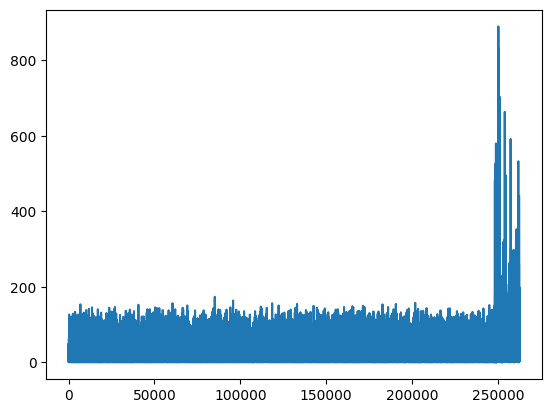

In [106]:
import statistics

print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [107]:
sentences = df.comment.values
labels = df.toxic.values

**Split**

In [108]:
# X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
# print(X_train.shape)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941   .25
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
print(X_train.shape)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42) # .1764705882352941   .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(210161,)
(210161,)
(26270,)
(26271,)


In [109]:
# X_train=X_train[:10]
# y_train=y_train[:10]
# X_val=X_val[:10]
# y_val=y_val[:10]
# X_test=X_test[:10]
# y_test=y_test[:10]

In [110]:
X_train.shape

(210161,)

In [111]:
y_train.shape

(210161,)

In [112]:
X_test.shape

(26270,)

In [113]:
y_test.shape

(26270,)

In [114]:
X_val.shape

(26271,)

In [115]:
y_val.shape

(26271,)

In [116]:
X_train.shape

(210161,)

In [117]:
y_train.shape

(210161,)

In [118]:
from navec import Navec

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
PATH_NAVEC = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

if not os.path.exists(PATH_NAVEC):
    wget.download(url)
navec = Navec.load(PATH_NAVEC)

In [119]:
NAVEC_UNK= '<unk>'
NAVEC_PAD= '<pad>'
DIMENSION_EMBEDDING=navec.get('<unk>').shape[0]

In [120]:
def vectorize_sentence(sentence: str, vectorizer=navec,unc_token =NAVEC_UNK, pad_token = NAVEC_PAD, max_sequence_length=64) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [navec.get(t, navec[unc_token]) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [navec[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

**Анализ датасета**

https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/src/dataset_analysis.ipynb

In [121]:
sequence_length=64

In [122]:
navec.get('<unk>').shape[0]

300

In [123]:
# X_train = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_train.flatten()
#     )
# ))

# X_val = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_val.flatten()
#     )
# ))

# X_test = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_test.flatten()
#     )
# ))


In [124]:
X_train.shape

(210161,)

**Build RNN model**

Model: "Glove-Navec_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 62, 256)           230656    
                                                                 
 gru_2 (GRU)                 (None, 128)               148224    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 387,201
Trainable params: 387,201
Non

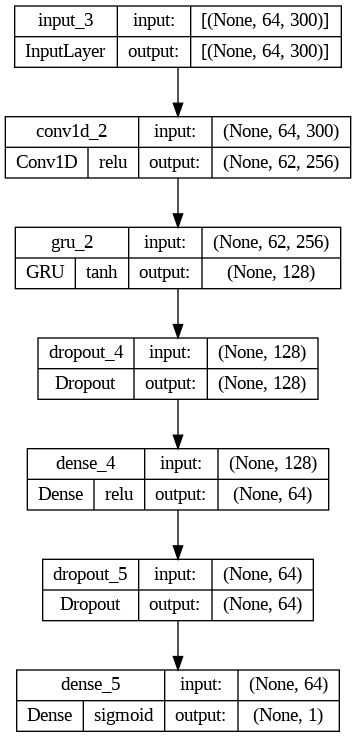

In [125]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Conv1D,GlobalMaxPool1D,SpatialDropout1D,GRU
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
EPOCHS = 21
BATCH_SIZE = 512
MODEL_NAME = 'Glove-Navec_CNN'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    GRU(128, dropout=0.3, recurrent_dropout=0.1),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

# Пробуем

In [126]:
X_test[:2]

array(['классный фигурка',
       'я уехать по семейный обстоятельство родитель быть пожилой они хотеться на родина дожить себя дом'],
      dtype=object)

In [127]:
import math
class Dataset(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.x))
        batch_x = self.x[low:high]
        batch_y = self.y[low:high]
        ###################

        batch_x = np.array(list(map(
            lambda sentence:vectorize_sentence(
                sentence,
                vectorizer=navec,
                unc_token =NAVEC_UNK,
                pad_token = NAVEC_PAD,
                max_sequence_length=sequence_length),
            batch_x.ravel()
            )
        ))

        ###################

        return batch_x, batch_y

In [128]:
BATCH_SIZE

512

In [129]:
train_gen = Dataset(x_set=X_train,y_set=y_train,batch_size=BATCH_SIZE)

val_gen = Dataset(x_set=X_val,y_set=y_val,batch_size=BATCH_SIZE)
x,y = train_gen.__getitem__(1)

In [130]:
x.shape

(512, 64, 300)

# ПРОБУЕМ 

In [131]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

# history = model.fit(
#     x=X_train,
#     y=y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_val,y_val),
#     callbacks=[early_stopping],
#     class_weight=calculate_weights(neutral_count, negative_count),
# )

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/21
411/411 [==============================] - 240s 572ms/step - loss: 0.6317 - tp: 19442.0000 - fp: 56804.0000 - tn: 113945.0000 - fn: 19970.0000 - accuracy: 0.6347 - precision: 0.2550 - recall: 0.4933 - auc: 0.6432 - prc: 0.3752 - val_loss: 0.2855 - val_tp: 4280.0000 - val_fp: 1788.0000 - val_tn: 19518.0000 - val_fn: 685.0000 - val_accuracy: 0.9059 - val_precision: 0.7053 - val_recall: 0.8620 - val_auc: 0.9626 - val_prc: 0.8927
Epoch 2/21
411/411 [==============================] - 210s 511ms/step - loss: 0.2363 - tp: 34989.0000 - fp: 15135.0000 - tn: 155614.0000 - fn: 4423.0000 - accuracy: 0.9069 - precision: 0.6980 - recall: 0.8878 - auc: 0.9661 - prc: 0.8949 - val_loss: 0.1828 - val_tp: 4266.0000 - val_fp: 1190.0000 - val_tn: 20116.0000 - val_fn: 699.0000 - val_accuracy: 0.9281 - val_precision: 0.7819 - val_recall: 0.8592 - val_auc: 0.9738 - val_prc: 0.9211
Epoch 3/21
411/411 [==============================] - 215s 523ms/step - loss: 0.2015 - tp: 35837.0000 - fp: 13348.0000 

**Save model**

In [132]:
model.save(MODEL_NAME)

In [133]:
# X_test = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_test.flatten()
#     )
# ))

In [134]:
test_gen = Dataset(x_set=X_test,y_set=y_test,batch_size=BATCH_SIZE)

In [135]:
pred = model.predict(test_gen).flatten()

52/52 [==============================] - 10s 183ms/step


In [136]:
pred

array([3.3888101e-04, 9.8207011e-04, 8.2952892e-03, ..., 3.1804535e-04,
       2.2767424e-03, 4.2226779e-01], dtype=float32)

In [137]:
pred.shape

(26270,)

In [138]:
type(pred)

numpy.ndarray

In [139]:
pred[2]

0.008295289

In [140]:
# threshold =0.5
# pred = np.where(pred<threshold,0,1)

In [141]:
pred

array([3.3888101e-04, 9.8207011e-04, 8.2952892e-03, ..., 3.1804535e-04,
       2.2767424e-03, 4.2226779e-01], dtype=float32)

In [142]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def plot_cm(labels, predictions, p=0.5):
  predictions = np.where(predictions <p,0,1)
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 21})
  plt.rc('axes', titlesize=16)
  plt.rc('axes', labelsize=14)
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  # plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.title('Матрица ошибок')
  plt.ylabel('Актуальное значение')
  plt.xlabel('Прогнозируемое значение')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(labels, predictions)))
  print("Recall: {0:.2f} %".format(100 * recall_score(labels, predictions)))
  print("Precision: {0:.2f} %".format(100 * precision_score(labels, predictions)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(labels, predictions)))  
  precision, recall, f1score = precision_recall_fscore_support(labels, predictions, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(labels, predictions,digits=4))
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 92.83 %
Recall: 89.34 %
Precision: 77.06 %
F1-score: 82.75 % 

precision: 0.8721009948075998, recall: 0.9150016921322119, f1score: 0.8911092160249707
              precision    recall  f1-score   support

           0     0.9736    0.9367    0.9548     21216
           1     0.7706    0.8934    0.8275      5054

    accuracy                         0.9283     26270
   macro avg     0.8721    0.9150    0.8911     26270
weighted avg     0.9345    0.9283    0.9303     26270

True Negatives:  19872
False Positives:  1344
False Negatives:  539
True Positives:  4515


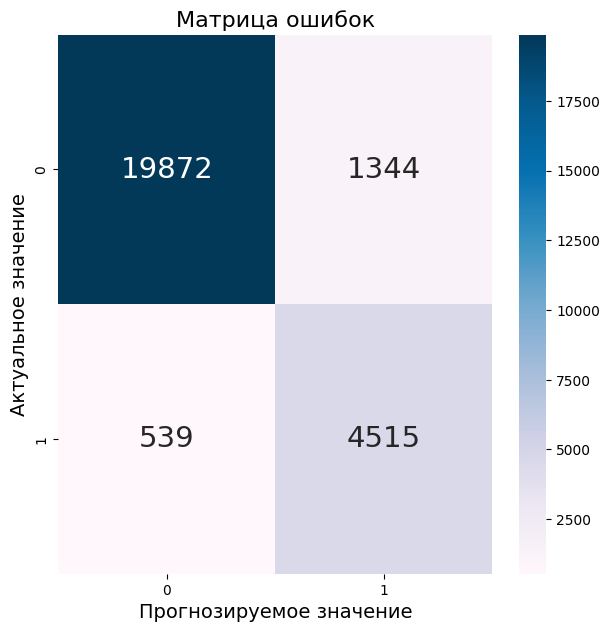

In [143]:
plot_cm(y_test, pred)

In [144]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

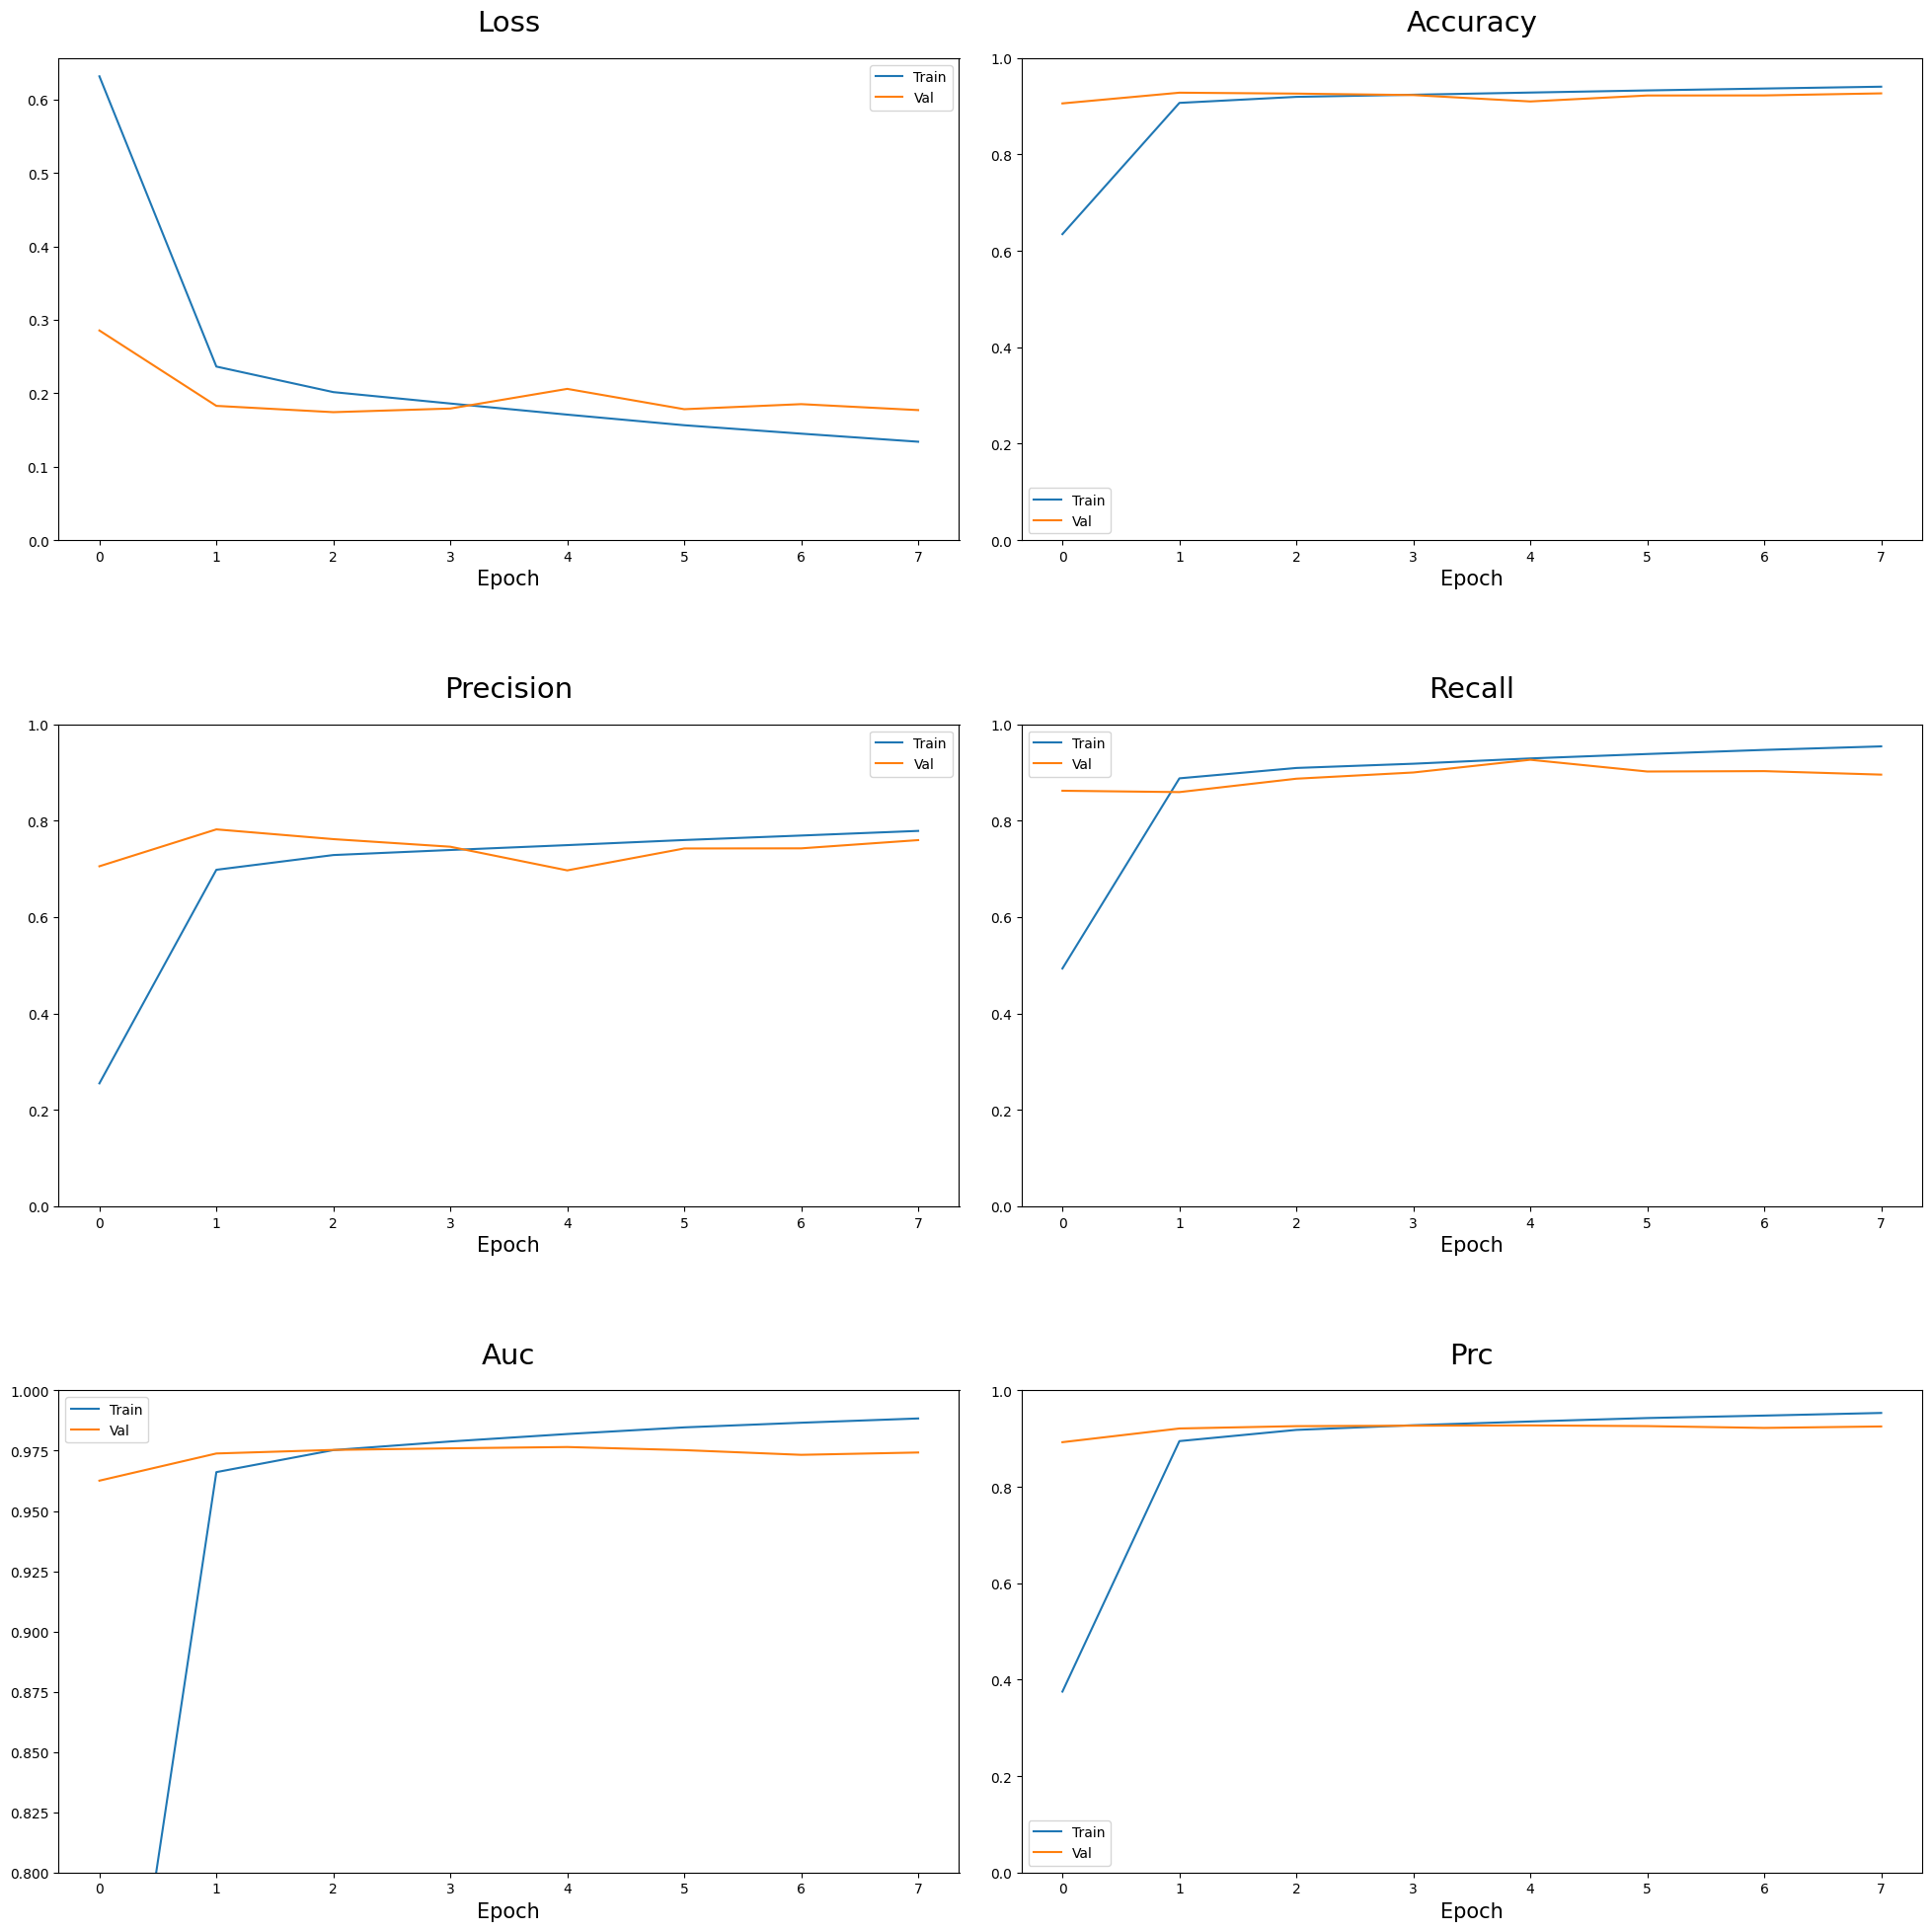

In [145]:
plot_metrics(history)

**Show ROC - curve**

: ROC AUC=0.978
treshold
[1.9998240e+00 9.9982411e-01 9.9975437e-01 ... 1.4872655e-04 1.4756214e-04
 1.2982021e-04]


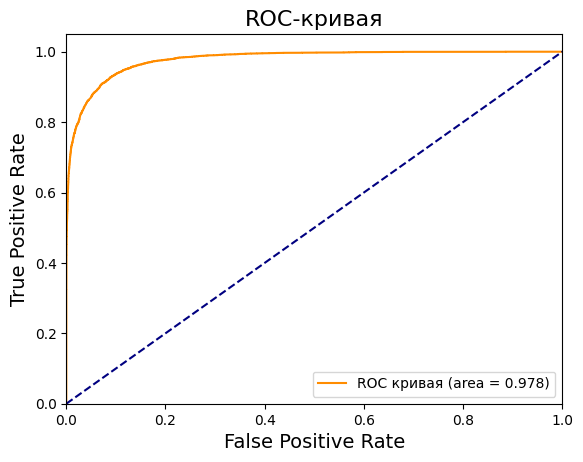

Best F1-Score:  0.8465533041441807
Best threshold:  0.67964315
Accuracy: 94.26 %
Recall: 82.25 %
Precision: 87.20 %
F1-score: 84.66 % 

precision: 0.9151609054877342, recall: 0.8968824664960806, f1score: 0.905638130571119
              precision    recall  f1-score   support

           0     0.9583    0.9712    0.9647     21216
           1     0.8720    0.8225    0.8466      5054

    accuracy                         0.9426     26270
   macro avg     0.9152    0.8969    0.9056     26270
weighted avg     0.9417    0.9426    0.9420     26270

True Negatives:  20606
False Positives:  610
False Negatives:  897
True Positives:  4157


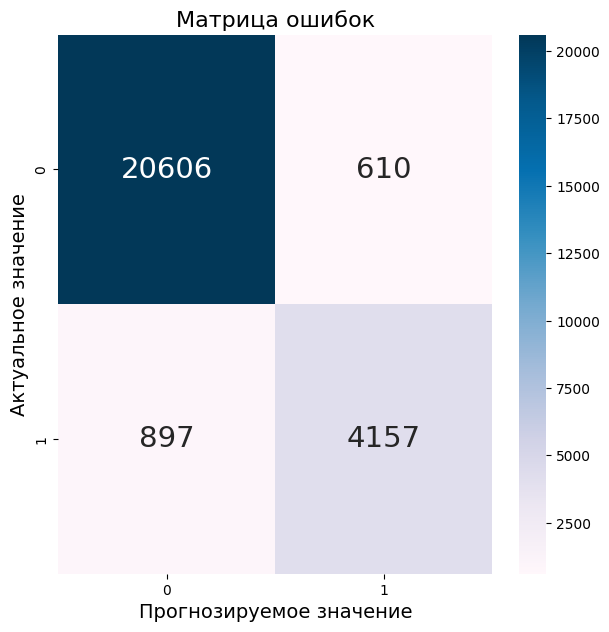

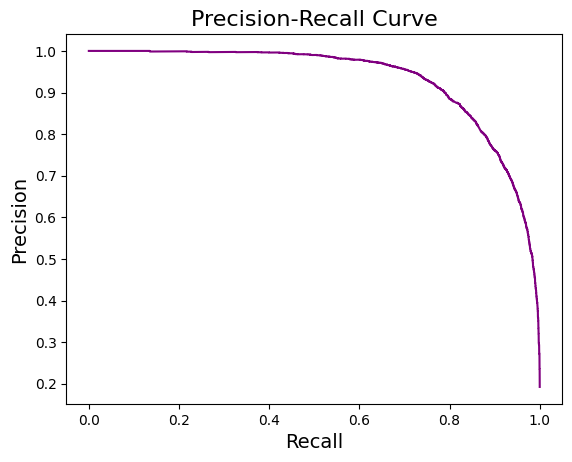

In [146]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
# сохраняем вероятности только для положительного исхода
lr_probs = pred

# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(': ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

print('treshold')
print(treshold)

# размеры шрифта
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
# строим график
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right",)
plt.show()
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs)
numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
max_f1 = np.max(f1_scores)
max_f1_thresh = thresholds[np.argmax(f1_scores)]
print('Best F1-Score: ',max_f1)
print('Best threshold: ',max_f1_thresh)
plot_cm(y_test,lr_probs, p=max_f1_thresh)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show() 

In [147]:
hjhjhhj=6+5

In [148]:
antiInterrupt = 89+0

In [ ]:
8778+90